In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from openbustools.traveltime import grids, data_loader
from openbustools import data_utils, plotting, spatial

In [2]:
network_name = 'kcm'
data_folder = '../data/kcm_realtime/processed/'
train_date = '2023_03_15'
train_n = 3
train_dates = data_utils.get_date_list(train_date, int(train_n))
train_dataset = data_loader.ContentDataset(data_folder, train_dates)
data_df = train_dataset.data
data_df.head()

,trip_id,file,locationtime,lat,lon,vehicle_id,geometry,x_cent,y_cent,calc_time_s,...,service_id,route_id,direction_id,calc_stop_dist_km,pass_stops_n,t_sec_of_day_start,sch_time_s,cumul_time_s,cumul_dist_km,cumul_pass_stops_n
shingle_id,,,,,,,,,,,,,,,,,,,,,
0,347458212,2023_03_15,1678886840,47.774170,-122.342987,7328,POINT (386862.532 87183.326),-47.468344,18161.325690,20.0,...,50510,100201,1,0.148500,0,23240.0,-20.0,0.0,0.000000,0
0,347458212,2023_03_15,1678886860,47.774464,-122.342262,7328,POINT (386917.483 87214.912),7.482863,18192.911647,20.0,...,50510,100201,1,0.092371,0,23240.0,-20.0,20.0,0.063385,0
0,347458212,2023_03_15,1678886896,47.774464,-122.340981,7328,POINT (387013.527 87213.029),103.526909,18191.029020,36.0,...,50510,100201,1,0.008621,0,23240.0,-20.0,56.0,0.159451,0
0,347458212,2023_03_15,1678886936,47.774166,-122.338356,7328,POINT (387209.542 87176.104),299.541696,18154.103781,40.0,...,50510,100201,1,0.108914,1,23240.0,-19.0,96.0,0.358921,1
0,347458212,2023_03_15,1678887039,47.777657,-122.331963,7328,POINT (387696.179 87554.753),786.178817,18532.752937,103.0,...,50510,100201,1,0.244771,2,23240.0,47.0,199.0,0.975542,3


### Traces

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

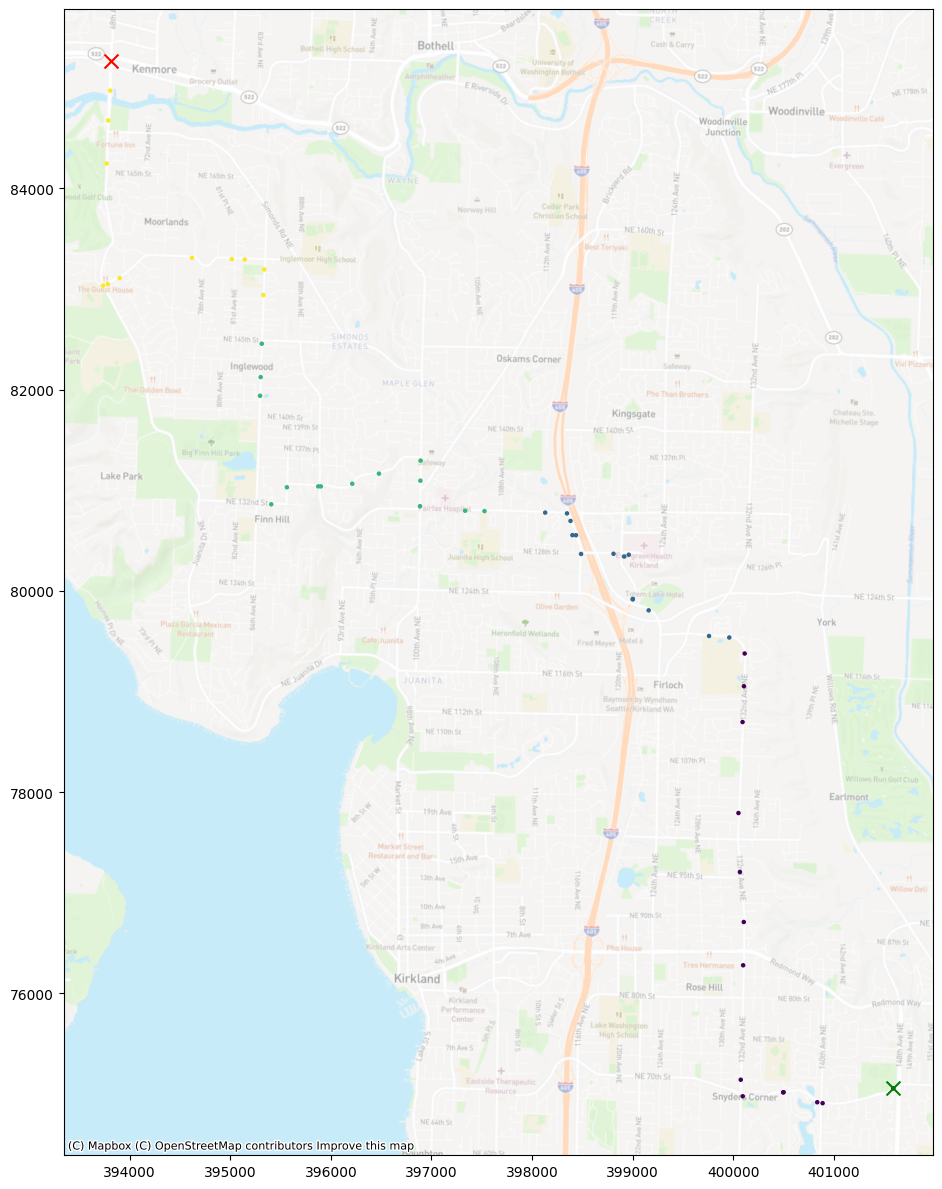

In [3]:
sample = data_df.sample(1)
sample_df = data_df[data_df['file']==sample['file'].to_numpy()[0]]
sample_df = sample_df[sample_df['trip_id']==sample['trip_id'].to_numpy()[0]].reset_index()
plotting.formatted_shingle_scatterplot(sample_df)

### Feature Distributions

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(<Figure size 800x600 with 4 Axes>,
 array([<Axes: xlabel='Observations (n)', ylabel='Count'>,
        <Axes: xlabel='Travel Dist (km)', ylabel='Count'>,
        <Axes: xlabel='Travel Time (s)', ylabel='Count'>,
        <Axes: xlabel='Scheduled Time (s)', ylabel='Count'>], dtype=object))

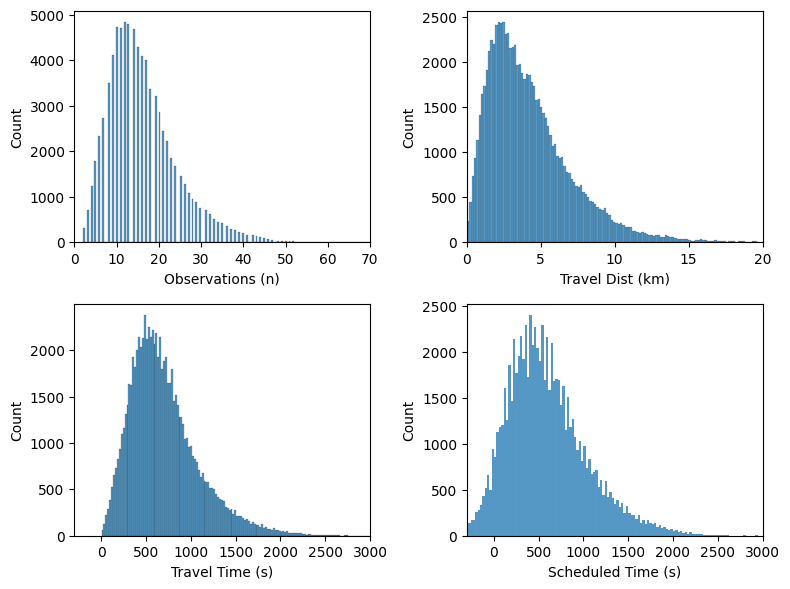

In [5]:
plotting.formatted_feature_distributions_histplot(data_df)

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout()
axes = axes.flatten()

metric = data_df.groupby(['shingle_id']).count()['lat']
sns.histplot(metric, ax=axes[0])
axes[0].set_title(f"Shingle Metrics")
axes[0].set_xlabel("Observations (n)")
axes[0].set_xlim(0,70)

metric = data_df.groupby('shingle_id').last()['cumul_dist_km']
sns.histplot(metric, ax=axes[1])
axes[1].set_xlabel("Travel Dist (m)")
axes[1].set_xlim(0,20000)

metric = data_df.groupby('shingle_id').sum(numeric_only=True)['calc_time_s']
sns.histplot(metric, ax=axes[2])
axes[2].set_xlabel("Travel Time (s)")
axes[2].set_xlim(0,3000)

# metric = data_df.groupby('shingle_id').last()['scheduled_time_s']


### Grid

In [ ]:
ngrid_kcm = grids.NGridBetter(kcm_inputs['summary_config']['grid_bounds'][0], 500)
ngrid_kcm.add_grid_content(kcm_inputs['train_traces'], trace_format=True)
ngrid_kcm.build_cell_lookup()
ngrid_atb = grids.NGridBetter(atb_inputs['summary_config']['grid_bounds'][0], 500)
ngrid_atb.add_grid_content(atb_inputs['train_traces'], trace_format=True)
ngrid_atb.build_cell_lookup()

In [ ]:
# Examine ngrid
print(f"KCM ngrid points: {ngrid_kcm.points.shape}")
for i in range(ngrid_kcm.points.shape[1]):
    print(f"KCM ngrid feature {i}, mean: {np.mean(ngrid_kcm.points[:,i])}, std: {np.std(ngrid_kcm.points[:,i])}, min: {np.min(ngrid_kcm.points[:,i])}, max: {np.max(ngrid_kcm.points[:,i])}")
print(f"AtB ngrid points: {ngrid_atb.points.shape}")
for i in range(ngrid_atb.points.shape[1]):
    print(f"AtB ngrid feature {i}, mean: {np.mean(ngrid_atb.points[:,i])}, std: {np.std(ngrid_atb.points[:,i])}, min: {np.min(ngrid_atb.points[:,i])}, max: {np.max(ngrid_atb.points[:,i])}")

In [ ]:
# # Look at 1 KCM trip
# train_traces = kcm_inputs['train_traces']
# sample = train_traces[train_traces['shingle_id']==np.unique(train_traces.shingle_id)[0]]
# xbin_idxs, ybin_idxs = ngrid_kcm.digitize_points(sample['x'], sample['y'])
# grid_features = ngrid_kcm.get_grid_features(xbin_idxs, ybin_idxs, sample['locationtime'])
# print(grid_features.shape) # (tsteps, channels, samples, ysteps, xsteps)
# # Select 1st sample for plotting
# grid_features_plot = grid_features[:,:,0,:,:]
# grids.save_grid_anim(grid_features_plot, "grid_n_shingle_kcm.mp4")

In [ ]:
# # Look at 1 AtB trip
# train_traces = atb_inputs['train_traces']
# sample = train_traces[train_traces['shingle_id']==np.unique(train_traces.shingle_id)[0]]
# xbin_idxs, ybin_idxs = ngrid_atb.digitize_points(sample['x'], sample['y'])
# grid_features = ngrid_atb.get_grid_features(xbin_idxs, ybin_idxs, sample['locationtime'])
# print(grid_features.shape) # (tsteps, channels, samples, ysteps, xsteps)
# # Select 1st sample for plotting
# grid_features_plot = grid_features[:,:,0,:,:]
# grids.save_grid_anim(grid_features_plot, "grid_n_shingle_atb.mp4")

In [ ]:
# # Save plots of full ngrid features
# ngrid_features = ngrid_kcm.get_full_grid(240)
# print(ngrid_features.shape) # (tsteps, channels, latteps, lonsteps)
# ngrid_features = ngrid_features[:500,:,0,:,:] # Look at only first sample, first 16hrs
# grids.save_grid_anim(ngrid_features, "grid_n_kcm.mp4")

In [ ]:
# # Save plots of full ngrid features
# ngrid_features = ngrid_atb.get_full_grid(240)
# print(ngrid_features.shape) # (tsteps, channels, latteps, lonsteps)
# ngrid_features = ngrid_features[:500,:,0,:,:] # Look at only first sample, first 16hrs
# grids.save_grid_anim(ngrid_features, "grid_n_atb.mp4")

### Adjacent Trips

In [ ]:
# # Run parameters
# shingle_sample_size = 200
# d_buffers = np.linspace(1,1000,20)
# t_buffers = np.linspace(1,60*20,20)
# b_buffer = None
# orthogonal = False

# # Look at speed correlation between adjacent bus trips
# if NETWORK=="kcm":
#     traces = kcm_inputs['test_traces']
# else:
#     traces = atb_inputs['test_traces']
# # Look at only a single hour for the sake of speed (assumes loaded test data comes from single day)
# traces = traces[traces.time<10*60]
# traces = traces[traces.time>=9*60]
# shingle_ids = pd.unique(traces['shingle_id'])
# shingle_id_sample = np.random.choice(shingle_ids, shingle_sample_size, replace=False)

# # Test shingle data against all other data
# shingle_traces = traces[traces['shingle_id'].isin(shingle_id_sample)][['x','y','locationtime','bearing','speed_m_s','shingle_id']]
# shingle_groups = shingle_traces.groupby('shingle_id')
# adj_traces = traces[~traces['shingle_id'].isin(shingle_id_sample)][['x','y','locationtime','bearing','speed_m_s']].values
# # Save results for each shingle, and buffer combination
# targets_res = np.zeros((len(shingle_id_sample), len(d_buffers), len(t_buffers)))
# preds_res = np.zeros((len(shingle_id_sample), len(d_buffers), len(t_buffers)))

# # Parallel: 1min with 200 samples, 20x20 buffers, 1hr data
# # Each item in the results corresponds to a distance buffer; it has n subitems, 1 for each time buffer
# # Within a d-t buffer, there are 4 values; (targets, preds, d_buffer idx, t_buffer idx)
# def parallel_get_metrics(d):
#     dist_buffer = d_buffers[d]
#     results = []
#     for t, t_buffer in enumerate(t_buffers):
#         res = shingle_groups.apply(shape_utils.get_adjacent_metric, adj_traces, dist_buffer, t_buffer, b_buffer=b_buffer, orthogonal=orthogonal)
#         targets = np.array([x[0] for x in res])
#         preds = np.array([x[1] for x in res])
#         results.append((targets, preds, d, t))
#     return results
# res_parallel = Parallel(n_jobs=-2)(delayed(parallel_get_metrics)(x) for x in range(len(d_buffers)))

# # Expand parallel adjacent metric results
# for d_idx in range(len(res_parallel)):
#     for t_idx in range(len(res_parallel[0])):
#         targets = res_parallel[d_idx][t_idx][0]
#         preds = res_parallel[d_idx][t_idx][1]
#         targets_res[:,d_idx,t_idx] = targets
#         preds_res[:,d_idx,t_idx] = preds
# # Get R2 value for each combination of preds and targets and for each d and t buffer
# r_values = np.empty((preds_res.shape[1], preds_res.shape[2]))
# slope_mean = 0.0
# slope_ct = 0
# for d in range(preds_res.shape[1]):
#     for t in range(preds_res.shape[2]):
#         try:
#             non_nan_preds = preds_res[:,d,t][~np.isnan(preds_res[:,d,t])]
#             non_nan_targs = targets_res[:,d,t][~np.isnan(preds_res[:,d,t])]
#             if len(non_nan_preds)>1:
#                 slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(non_nan_preds, non_nan_targs)
#                 r_values[d,t] = r_value**2
#                 slope_mean += slope
#                 slope_ct += 1
#             else:
#                 r_values[d,t] = np.nan
#         except:
#             r_values[d,t] = np.nan
            
# # Plot results for all d/t combos
# print(f"Average slope: {slope_mean / slope_ct}")
# fig, ax = plt.subplots()
# im = ax.imshow(r_values, origin="lower", cmap="plasma")
# fig.suptitle("R2 of Linear Fit to Mean Adjacent Speeds")
# ax.set_title(f"B={b_buffer} deg, Orth={str(orthogonal)}, Net={NETWORK}")
# ax.set_xlabel("Time (s)")
# ax.set_xticks([x for x in range(len(t_buffers))])
# ax.set_xticklabels([str(int(x)) for x in t_buffers], rotation=45)
# ax.set_ylabel("Distance (m)")
# ax.set_yticks([y for y in range(len(d_buffers))])
# ax.set_yticklabels([str(int(y)) for y in d_buffers])
# cbar = fig.colorbar(im, ax=ax)
# plt.draw()
# plt.savefig(f"../plots/R2_adj_{b_buffer}_{str(orthogonal)}_{NETWORK}.png", dpi=600, bbox_inches='tight')
# plt.show()